In [72]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

PROJECT_ROOT = '/content/drive/MyDrive/perceptual-vits-fashion-forecasting'
sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import torch
import torchvision.models as models

rows = []

deep_vision_model_path = os.path.join(PROJECT_ROOT, 'vision_models')

cnn_path = os.path.join(deep_vision_model_path, 'cnn_backbone_models')
vits_path = os.path.join(deep_vision_model_path, 'vits_backbone_models')

In [74]:
# Load ResNet50
resnet_50_path = os.path.join(cnn_path, 'resnet50_imagenet.pth')
resnet_50 = models.resnet50(weights=None)
state_dict = torch.load(resnet_50_path, map_location='cpu')
resnet_50.load_state_dict(state_dict)

# Collect information about ResNet50
rows.append({
    'model': 'ResNet50',
    'family': 'CNN',
    'tuning': 'MLP',
    'params_backbone': sum(p.numel() for p in resnet_50.parameters()),
    'mae_vanilla': 14.344,
    'mae_nights': 13.624
})

In [75]:
!pip install openai-clip

In [76]:
import clip

# Load CLIP32
device = 'cpu'
clip_model32, _ = clip.load('ViT-B/32', device=device)
clip_vision32 = clip_model32.visual

# Collect information about CLIP32 MLP
rows.append({
    'model': 'CLIP32',
    'family': 'ViT',
    'tuning': 'MLP',
    'params_backbone': sum(p.numel() for p in clip_vision32.parameters()),
    'mae_vanilla': 13.3897,
    'mae_nights': 13.580
})

# Collect information about CLIP32 LoRA
rows.append({
    'model': 'CLIP32',
    'family': 'ViT',
    'tuning': 'LoRA',
    'params_backbone': sum(p.numel() for p in clip_vision32.parameters()),
    'mae_vanilla': 13.3897,
    'mae_nights': 13.418
})

In [77]:
# Load CLIP16
device = 'cpu'
clip_model16, _ = clip.load('ViT-B/16', device=device)
clip_vision16 = clip_model16.visual

# Collect information about CLIP16 MLP
rows.append({
    'model': 'CLIP16',
    'family': 'ViT',
    'tuning': 'MLP',
    'params_backbone': sum(p.numel() for p in clip_vision32.parameters()),
    'mae_vanilla': 13.700,
    'mae_nights': 13.505
})

# Collect information about CLIP16 LoRA
rows.append({
    'model': 'CLIP16',
    'family': 'ViT',
    'tuning': 'LoRA',
    'params_backbone': sum(p.numel() for p in clip_vision32.parameters()),
    'mae_vanilla': 13.700,
    'mae_nights': 13.429
})

In [78]:
import torchvision.models as tv_models
from torchvision.models.vision_transformer import vit_b_16

# Load DINOv1
device = "cpu"
dinov1 = vit_b_16(weights=None).to(device)

# Collect information about DINOv1 MLP
rows.append({
    'model': 'DINOv1',
    'family': 'ViT',
    'tuning': 'MLP',
    'params_backbone': sum(p.numel() for p in dinov1.parameters()),
    'mae_vanilla': 13.848,
    'mae_nights': 13.431
})

# Collect information about DINOv1 LoRA
rows.append({
    'model': 'DINOv1',
    'family': 'ViT',
    'tuning': 'LoRA',
    'params_backbone': sum(p.numel() for p in dinov1.parameters()),
    'mae_vanilla': 13.848,
    'mae_nights': 13.360
})

In [79]:
# Load DINOv2
dinov2 = torch.hub.load(
    'facebookresearch/dinov2',
    'dinov2_vitb14',
    pretrained=True
).to(device)

# Collect information about DINOv2 LoRA
rows.append({
    'model': 'DINOv2',
    'family': 'ViT',
    'tuning': 'LoRA',
    'params_backbone': sum(p.numel() for p in dinov2.parameters()),
    'mae_vanilla': 14.378,
    'mae_nights': 13.542
})

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [80]:
# Load DINOv3
dinov3 = torch.hub.load(
    'facebookresearch/dinov2',
    'dinov2_vitl14',
    pretrained=True
).to(device)

# Collect information about DINOv3 LoRA
rows.append({
    'model': 'DINOv3',
    'family': 'ViT',
    'tuning': 'LoRA',
    'params_backbone': sum(p.numel() for p in dinov3.parameters()),
    'mae_vanilla': 13.655,
    'mae_nights': 13.484
})

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [81]:
import pandas as pd

df = pd.DataFrame(rows)
df_clean = df[df['model'] != 'CLIP32']

mlp_df = df_clean[df_clean['tuning'] == 'MLP']
lora_df = df_clean[df_clean['tuning'] == 'LoRA']

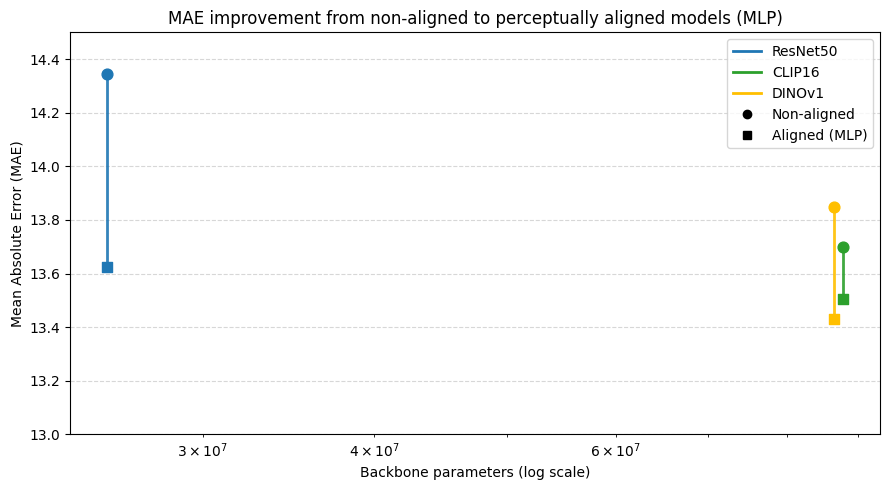

In [107]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# -----------------------
# Manual color mapping
# -----------------------
color_map = {
    'ResNet50': '#1f77b4',   # blue
    'CLIP16':   '#2ca02c',   # green
    'DINOv1':   '#ffbf00',   # yellow / amber
}

plt.figure(figsize=(9, 5))

for _, row in mlp_df.iterrows():
    x = row['params_backbone']
    y_non_aligned = row['mae_vanilla']
    y_aligned = row['mae_nights']
    model_name = row['model']
    color = color_map[model_name]

    plt.plot([x, x], [y_non_aligned, y_aligned],
             color=color, linewidth=2, alpha=0.9)

    plt.scatter(x, y_non_aligned, marker='o', s=60,
                color=color, zorder=3)

    plt.scatter(x, y_aligned, marker='s', s=60,
                color=color, zorder=3)

# Axes
plt.xscale('log')
plt.xlabel('Backbone parameters (log scale)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE improvement from non-aligned to perceptually aligned models (MLP)')

plt.ylim(13.0, 14.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Legends
model_legend = [
    Line2D([0], [0], color=color_map[m], lw=2, label=m)
    for m in color_map
]

alignment_legend = [
    Line2D([0], [0], marker='o', linestyle='None',
           color='black', label='Non-aligned'),
    Line2D([0], [0], marker='s', linestyle='None',
           color='black', label='Aligned (MLP)')
]

plt.legend(handles=model_legend + alignment_legend, loc='upper right')

plt.tight_layout()
plt.show()


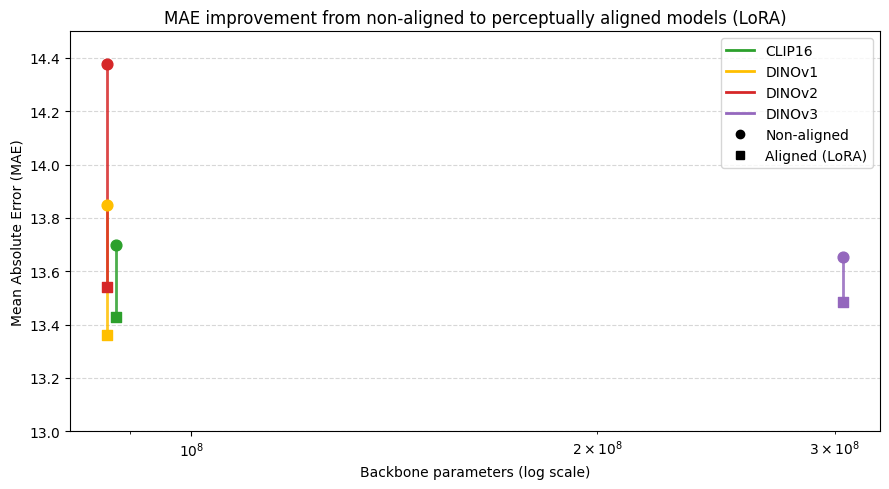

In [108]:
# -----------------------
# Manual color mapping
# -----------------------
color_map = {
    'CLIP16':  '#2ca02c',   # green
    'DINOv1':  '#ffbf00',   # yellow / amber
    'DINOv2':  '#d62728',   # red
    'DINOv3':  '#9467bd',   # purple
}

plt.figure(figsize=(9, 5))

for _, row in lora_df.iterrows():
    x = row['params_backbone']
    y_non_aligned = row['mae_vanilla']
    y_aligned = row['mae_nights']
    model_name = row['model']
    color = color_map[model_name]

    plt.plot([x, x], [y_non_aligned, y_aligned],
             color=color, linewidth=2, alpha=0.85)

    plt.scatter(x, y_non_aligned, marker='o', s=60,
                color=color, zorder=3)

    plt.scatter(x, y_aligned, marker='s', s=60,
                color=color, zorder=3)

# Axes
plt.xscale('log')
plt.xlabel('Backbone parameters (log scale)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE improvement from non-aligned to perceptually aligned models (LoRA)')

plt.ylim(13.0, 14.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Legends
model_legend = [
    Line2D([0], [0], color=color_map[m], lw=2, label=m)
    for m in color_map
]

alignment_legend = [
    Line2D([0], [0], marker='o', linestyle='None',
           color='black', label='Non-aligned'),
    Line2D([0], [0], marker='s', linestyle='None',
           color='black', label='Aligned (LoRA)')
]

plt.legend(handles=model_legend + alignment_legend, loc='upper right')

plt.tight_layout()
plt.show()


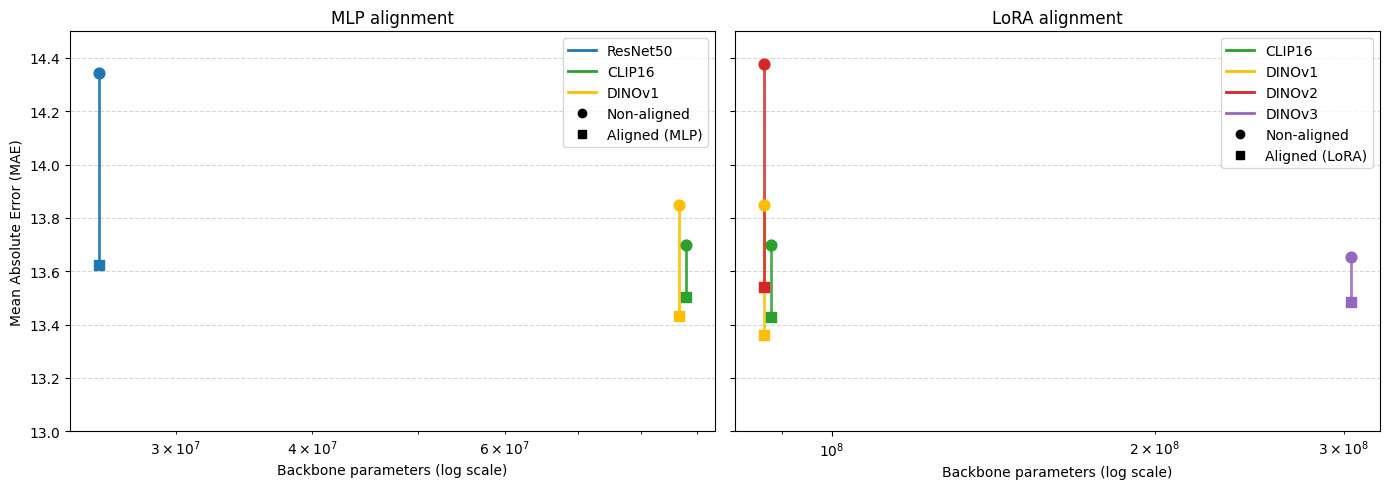

Figure saved to: /content/drive/MyDrive/perceptual-vits-fashion-forecasting/visualizations/relation_model_size_and_effect_of_perceptual_alignment.png


In [115]:
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -----------------------
# Manual color mappings
# -----------------------
color_map_mlp = {
    'ResNet50': '#1f77b4',   # blue
    'CLIP16':   '#2ca02c',   # green
    'DINOv1':   '#ffbf00',   # yellow
}

color_map_lora = {
    'CLIP16':  '#2ca02c',   # green
    'DINOv1':  '#ffbf00',   # yellow
    'DINOv2':  '#d62728',   # red
    'DINOv3':  '#9467bd',   # purple
}

# -----------------------
# Create facet plot
# -----------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)

# ======================================================
# Left panel: MLP
# ======================================================
ax = axes[0]

for _, row in mlp_df.iterrows():
    x = row['params_backbone']
    y0 = row['mae_vanilla']
    y1 = row['mae_nights']
    color = color_map_mlp[row['model']]

    ax.plot([x, x], [y0, y1], color=color, linewidth=2, alpha=0.9)
    ax.scatter(x, y0, marker='o', s=60, color=color, zorder=3)
    ax.scatter(x, y1, marker='s', s=60, color=color, zorder=3)

ax.set_xscale('log')
ax.set_ylim(13.0, 14.5)
ax.set_xlabel('Backbone parameters (log scale)')
ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_title('MLP alignment')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Legend (MLP)
ax.legend(
    handles=[
        Line2D([0], [0], color=color_map_mlp[m], lw=2, label=m)
        for m in color_map_mlp
    ] + [
        Line2D([0], [0], marker='o', linestyle='None',
               color='black', label='Non-aligned'),
        Line2D([0], [0], marker='s', linestyle='None',
               color='black', label='Aligned (MLP)')
    ],
    loc='upper right'
)

# ======================================================
# Right panel: LoRA
# ======================================================
ax = axes[1]

for _, row in lora_df.iterrows():
    x = row['params_backbone']
    y0 = row['mae_vanilla']
    y1 = row['mae_nights']
    color = color_map_lora[row['model']]

    ax.plot([x, x], [y0, y1], color=color, linewidth=2, alpha=0.85)
    ax.scatter(x, y0, marker='o', s=60, color=color, zorder=3)
    ax.scatter(x, y1, marker='s', s=60, color=color, zorder=3)

ax.set_xscale('log')
ax.set_ylim(13.0, 14.5)
ax.set_xlabel('Backbone parameters (log scale)')
ax.set_title('LoRA alignment')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Legend (LoRA)
ax.legend(
    handles=[
        Line2D([0], [0], color=color_map_lora[m], lw=2, label=m)
        for m in color_map_lora
    ] + [
        Line2D([0], [0], marker='o', linestyle='None',
               color='black', label='Non-aligned'),
        Line2D([0], [0], marker='s', linestyle='None',
               color='black', label='Aligned (LoRA)')
    ],
    loc='upper right'
)

# -----------------------
# Save figure
# -----------------------
viz_dir = os.path.join(PROJECT_ROOT, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

fig_path = os.path.join(
    viz_dir,
    'relation_model_size_and_effect_of_perceptual_alignment.png'
)

plt.tight_layout()
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {fig_path}")
